# Compute metrics across peak subsets

In [1]:
import sys
# append paths pointing to Data directory on your machine
sys.path.append('/home/katie/bp_repo/multitask_profile_model_SPI_GATA')

import pickle
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py

import profile_models
import profile_performance
from profile_performance import load_metrics, compute_performance_metrics, log_performance_metrics
from all_functions import save_preds_by_subset

sys.path.append('/home/katie/bp_repo/reports/')
from util import import_profiles

In [2]:
# set variables
date = 'jul16'
subsets_path_root = '/home/katie/bp_repo/reports/katie_notebooks/round2_tasks_mar2022/TASK_1/'
model_path_root = '/home/katie/bp_repo/pipeline_outputs/'
save_path_root = f'/home/katie/bp_repo/reports/katie_notebooks/summer2022_analysis/preds_by_subset_{date}/'

model_paths = list(model_path_root + stem + '/model.state_dict' for stem in [f'ctcf_chipseq_{date}',
                                                         f'ctcf_cutnrun_{date}', f'fosl2_chipseq_{date}', f'fosl2_cutnrun_{date}'])
models = list(profile_models.ModelLoader(model_path, controls='chipseq' in model_path, num_tasks=1).load_model() for \
             model_path in model_paths)

tfs = ['CTCF'] * 2 + ['FOSL2'] * 2
assays = ['chip-seq', 'cutnrun'] * 2
controls = list(assay == 'chip-seq' for assay in assays)
save_paths = list(save_path_root + tfs[i] + '/' + assays[i] + '_model/' for i in range(len(tfs)))
peak_subsets = ['unique', 'shared']


path_ids = ['CTCF chip-seq model', 'CTCF cutnrun model', 'FOSL2 chip-seq model', 'FOSL2 cutnrun model']

keys = ['shared_chip_loader',
 'shared_cut_loader',
 'unique_chip_loader',
 'unique_cut_loader']

data_ids = ['true_counts', 'log_pred_counts', 'true_profs', 'log_pred_profs']
plt.rcParams['figure.dpi'] = 100

colors = ['darkorange', 'firebrick', 'aqua', 'blue']

## Save preds by subset

In [17]:
# save preds by subset
for i in range(len(tfs)):
    model, tf, assay, control, save_path = models[i], tfs[i], assays[i], controls[i], save_paths[i]
    for peak_subset in peak_subsets:
        save_preds_by_subset(model, tf, assay, control, save_path, peak_subset, chrom_subset='full')
        
        

This is NOT the assay: cutnrun
Tasks path: /home/katie/bp_repo/research/data/chip-seq/
TSV path: CTCF_chip_unique_no_cut
CTCF
/home/katie/bp_repo/reports/katie_notebooks/round2_tasks_mar2022/TASK_1/CTCF_chip_unique_no_cut


  0%|          | 0/39 [00:00<?, ?it/s]

Saving result to HDF5...
Tasks path: /home/katie/bp_repo/research/data/cutnrun/
TSV path: CTCF_cut_unique_no_chip
CTCF
/home/katie/bp_repo/reports/katie_notebooks/round2_tasks_mar2022/TASK_1/CTCF_cut_unique_no_chip


  0%|          | 0/190 [00:00<?, ?it/s]

Saving result to HDF5...
This is NOT the assay: cutnrun
Tasks path: /home/katie/bp_repo/research/data/chip-seq/
TSV path: CTCF_chip_unique_shared_cut
CTCF
/home/katie/bp_repo/reports/katie_notebooks/round2_tasks_mar2022/TASK_1/CTCF_chip_unique_shared_cut


  0%|          | 0/241 [00:00<?, ?it/s]

Saving result to HDF5...
Tasks path: /home/katie/bp_repo/research/data/cutnrun/
TSV path: CTCF_cut_unique_shared_chip
CTCF
/home/katie/bp_repo/reports/katie_notebooks/round2_tasks_mar2022/TASK_1/CTCF_cut_unique_shared_chip


  0%|          | 0/235 [00:00<?, ?it/s]

Saving result to HDF5...
This is NOT the assay: chip-seq
Tasks path: /home/katie/bp_repo/research/data/cutnrun/
TSV path: CTCF_cut_unique_no_chip
CTCF
/home/katie/bp_repo/reports/katie_notebooks/round2_tasks_mar2022/TASK_1/CTCF_cut_unique_no_chip


  0%|          | 0/190 [00:00<?, ?it/s]

Saving result to HDF5...
Tasks path: /home/katie/bp_repo/research/data/chip-seq/
TSV path: CTCF_chip_unique_no_cut
CTCF
/home/katie/bp_repo/reports/katie_notebooks/round2_tasks_mar2022/TASK_1/CTCF_chip_unique_no_cut


  0%|          | 0/39 [00:00<?, ?it/s]

Saving result to HDF5...
This is NOT the assay: chip-seq
Tasks path: /home/katie/bp_repo/research/data/cutnrun/
TSV path: CTCF_cut_unique_shared_chip
CTCF
/home/katie/bp_repo/reports/katie_notebooks/round2_tasks_mar2022/TASK_1/CTCF_cut_unique_shared_chip


  0%|          | 0/235 [00:00<?, ?it/s]

Saving result to HDF5...
Tasks path: /home/katie/bp_repo/research/data/chip-seq/
TSV path: CTCF_chip_unique_shared_cut
CTCF
/home/katie/bp_repo/reports/katie_notebooks/round2_tasks_mar2022/TASK_1/CTCF_chip_unique_shared_cut


  0%|          | 0/241 [00:00<?, ?it/s]

Saving result to HDF5...
This is NOT the assay: cutnrun
Tasks path: /home/katie/bp_repo/research/data/chip-seq/
TSV path: FOSL2_chip_unique_no_cut
FOSL2
/home/katie/bp_repo/reports/katie_notebooks/round2_tasks_mar2022/TASK_1/FOSL2_chip_unique_no_cut


  0%|          | 0/55 [00:00<?, ?it/s]

Saving result to HDF5...
Tasks path: /home/katie/bp_repo/research/data/cutnrun/
TSV path: FOSL2_cut_unique_no_chip
FOSL2
/home/katie/bp_repo/reports/katie_notebooks/round2_tasks_mar2022/TASK_1/FOSL2_cut_unique_no_chip


  0%|          | 0/158 [00:00<?, ?it/s]

Saving result to HDF5...
This is NOT the assay: cutnrun
Tasks path: /home/katie/bp_repo/research/data/chip-seq/
TSV path: FOSL2_chip_unique_shared_cut
FOSL2
/home/katie/bp_repo/reports/katie_notebooks/round2_tasks_mar2022/TASK_1/FOSL2_chip_unique_shared_cut


  0%|          | 0/208 [00:00<?, ?it/s]

Saving result to HDF5...
Tasks path: /home/katie/bp_repo/research/data/cutnrun/
TSV path: FOSL2_cut_unique_shared_chip
FOSL2
/home/katie/bp_repo/reports/katie_notebooks/round2_tasks_mar2022/TASK_1/FOSL2_cut_unique_shared_chip


  0%|          | 0/199 [00:00<?, ?it/s]

Saving result to HDF5...
This is NOT the assay: chip-seq
Tasks path: /home/katie/bp_repo/research/data/cutnrun/
TSV path: FOSL2_cut_unique_no_chip
FOSL2
/home/katie/bp_repo/reports/katie_notebooks/round2_tasks_mar2022/TASK_1/FOSL2_cut_unique_no_chip


  0%|          | 0/158 [00:00<?, ?it/s]

Saving result to HDF5...
Tasks path: /home/katie/bp_repo/research/data/chip-seq/
TSV path: FOSL2_chip_unique_no_cut
FOSL2
/home/katie/bp_repo/reports/katie_notebooks/round2_tasks_mar2022/TASK_1/FOSL2_chip_unique_no_cut


  0%|          | 0/55 [00:00<?, ?it/s]

Saving result to HDF5...
This is NOT the assay: chip-seq
Tasks path: /home/katie/bp_repo/research/data/cutnrun/
TSV path: FOSL2_cut_unique_shared_chip
FOSL2
/home/katie/bp_repo/reports/katie_notebooks/round2_tasks_mar2022/TASK_1/FOSL2_cut_unique_shared_chip


  0%|          | 0/199 [00:00<?, ?it/s]

Saving result to HDF5...
Tasks path: /home/katie/bp_repo/research/data/chip-seq/
TSV path: FOSL2_chip_unique_shared_cut
FOSL2
/home/katie/bp_repo/reports/katie_notebooks/round2_tasks_mar2022/TASK_1/FOSL2_chip_unique_shared_cut


  0%|          | 0/208 [00:00<?, ?it/s]

Saving result to HDF5...


## Load in all test set predictions

In [3]:
# load in all test set predictions
all_preds_dict = {}

for i in range(len(save_paths)):
    path = save_paths[i]
    path_id = path_ids[i]
    preds_dict = {}
    
    # the surprisingly quick (few secs) actual preds loading
    for key in keys:
        file = h5py.File(f'{path}{key}.preds', 'r')
        coords = import_profiles(f'{path}{key}.preds')[2]
        preds_dict[key] = {'true_counts': file['predictions']['true_counts'], 
                           'log_pred_counts': file['predictions']['log_pred_counts'], 
                           'true_profs': file['predictions']['true_profs'],
                           'log_pred_profs': file['predictions']['log_pred_profs'], 
                           'coords': coords}
        
        # we need to subset to chr1, the test set
            # 1. take the coords, make into a DataFrame, subset to chr1, and get the indexes of the test coords
            # 2. use these indexes to subset pred_counts into the test profs
        df = pd.DataFrame(preds_dict[key]['coords']).reset_index()
        preds_dict[key]['coords_test'] = df[df.iloc[:,1] == 'chr1']
        preds_dict[key]['indexes_test'] = list(preds_dict[key]['coords_test']['index'])
        
        for data_id in data_ids:  # update all of the data to ONLY include test data
            preds_dict[key][data_id] = preds_dict[key][data_id][preds_dict[key]['indexes_test']]
    
    all_preds_dict[path_id] = preds_dict

Importing predictions:   0%|          | 0/62 [00:00<?, ?it/s]

Importing predictions:   0%|          | 0/60 [00:00<?, ?it/s]

Importing predictions:   0%|          | 0/10 [00:00<?, ?it/s]

Importing predictions:   0%|          | 0/49 [00:00<?, ?it/s]

Importing predictions:   0%|          | 0/62 [00:00<?, ?it/s]

Importing predictions:   0%|          | 0/60 [00:00<?, ?it/s]

Importing predictions:   0%|          | 0/10 [00:00<?, ?it/s]

Importing predictions:   0%|          | 0/49 [00:00<?, ?it/s]

Importing predictions:   0%|          | 0/54 [00:00<?, ?it/s]

Importing predictions:   0%|          | 0/51 [00:00<?, ?it/s]

Importing predictions:   0%|          | 0/14 [00:00<?, ?it/s]

Importing predictions:   0%|          | 0/41 [00:00<?, ?it/s]

Importing predictions:   0%|          | 0/54 [00:00<?, ?it/s]

Importing predictions:   0%|          | 0/51 [00:00<?, ?it/s]

Importing predictions:   0%|          | 0/14 [00:00<?, ?it/s]

Importing predictions:   0%|          | 0/41 [00:00<?, ?it/s]

## Save metrics (pickling)

In [7]:
# save metrics
# only need to run once
for i in range(len(path_ids)):
    path_id = path_ids[i]
    save_path = save_paths[i]
    for key in keys:
        preds_dict = all_preds_dict[path_id][key]
        true_profs, log_pred_profs, true_counts, log_pred_counts = \
        preds_dict['true_profs'], preds_dict['log_pred_profs'], preds_dict['true_counts'], preds_dict['log_pred_counts']
        metrics = profile_performance.compute_performance_metrics(
                true_profs, log_pred_profs, true_counts, log_pred_counts,
                prof_smooth_kernel_sigma=7, prof_smooth_kernel_width=81, print_updates=False
            )

        pickle.dump(profile_performance.log_performance_metrics(metrics), open(save_path + key + '_metrics.pkl', 'wb'))

	Test profile NLL: 213.575134
	Test profile cross entropy: 5.798069
	Test profile JSD: 0.123133
	Test profile Pearson: 0.792117
	Test profile Spearman: 0.591166
	Test profile MSE: 0.000002
	Test count Pearson: 0.373871
	Test count Spearman: 0.367228
	Test count MSE: 1.142587
	Test profile NLL: 617.331711
	Test profile cross entropy: 7.511798
	Test profile JSD: 0.358774
	Test profile Pearson: 0.128991
	Test profile Spearman: 0.301637
	Test profile MSE: 0.000008
	Test count Pearson: 0.205734
	Test count Spearman: 0.196943
	Test count MSE: 2.240740
	Test profile NLL: 118.343352
	Test profile cross entropy: 6.023574
	Test profile JSD: 0.215778
	Test profile Pearson: 0.631879
	Test profile Spearman: 0.499390
	Test profile MSE: 0.000004
	Test count Pearson: 0.230608
	Test count Spearman: 0.168726
	Test count MSE: 0.252090
	Test profile NLL: 190.401215
	Test profile cross entropy: 7.068994
	Test profile JSD: 0.330305
	Test profile Pearson: 0.080211
	Test profile Spearman: 0.150860
	Test profi

/home/katie/bp_repo/multitask_profile_model_SPI_GATA/profile_performance.py:43: RuntimeWarning: invalid value encountered in true_divide
  cross_ent = (-log_prob_pows_sum) / trials


	Test profile NLL: 60.309026
	Test profile cross entropy: 6.676916
	Test profile JSD: 0.400406
	Test profile Pearson: 0.235357
	Test profile Spearman: 0.324514
	Test profile MSE: 0.000010
	Test count Pearson: 0.195504
	Test count Spearman: 0.199235
	Test count MSE: 2.240366
	Test profile NLL: 559.431890
	Test profile cross entropy: 8.725475
	Test profile JSD: 0.368216
	Test profile Pearson: 0.168579
	Test profile Spearman: 0.264787
	Test profile MSE: 0.000020
	Test count Pearson: 0.184240
	Test count Spearman: 0.144004
	Test count MSE: 2.687772
	Test profile NLL: 106.422340
	Test profile cross entropy: 4.870600
	Test profile JSD: 0.374357
	Test profile Pearson: 0.281364
	Test profile Spearman: 0.333528
	Test profile MSE: 0.000020
	Test count Pearson: 0.270984
	Test count Spearman: 0.260356
	Test count MSE: 1.247520
	Test profile NLL: 296.518147
	Test profile cross entropy: 8.759840
	Test profile JSD: 0.395288
	Test profile Pearson: 0.132540
	Test profile Spearman: 0.197309
	Test profil

## Load metrics into pretty dataframe :]

In [4]:
pickles = []
ids = []
for i in range(len(path_ids)):
    path_id = path_ids[i]
    save_path = save_paths[i]
    for key in keys:
        pickles.append(save_path + key + '_metrics.pkl')
        ids.append(path_id + ' on ' + ' '.join(key.split('_')[:-1]) + ' peaks')

In [5]:
# OLD, WITHOUT MULTI-INDEXING
metrics = load_metrics(pickles, ids, multiindexing=False)

metrics = metrics.append(load_metrics([f'/home/katie/bp_repo/pipeline_outputs/ctcf_chipseq_{date}/metrics.pkl',
              f'/home/katie/bp_repo/pipeline_outputs/ctcf_cutnrun_{date}/metrics.pkl',
              f'/home/katie/bp_repo/pipeline_outputs/fosl2_chipseq_{date}/metrics.pkl',
              f'/home/katie/bp_repo/pipeline_outputs/fosl2_cutnrun_{date}/metrics.pkl'],
             ['CTCF chip-seq model on all test peaks', 'CTCF cutnrun model on all test peaks', 
              'FOSL2 chip-seq model on all test peaks', 'FOSL2 cutnrun model on all test peaks'], multiindexing=False))

In [8]:
# with multi-indexing :]
metrics = load_metrics(pickles, [path_ids, list(' '.join(key.split('_')) for key in keys)], multiindexing=True)
metrics = pd.concat([metrics, load_metrics([f'/home/katie/bp_repo/pipeline_outputs/ctcf_chipseq_{date}/metrics.pkl',
              f'/home/katie/bp_repo/pipeline_outputs/ctcf_cutnrun_{date}/metrics.pkl',
              f'/home/katie/bp_repo/pipeline_outputs/fosl2_chipseq_{date}/metrics.pkl',
              f'/home/katie/bp_repo/pipeline_outputs/fosl2_cutnrun_{date}/metrics.pkl'],
             [path_ids, ['all test peaks']], multiindexing=True)]).sort_index()
metrics = metrics.astype(float).round(2)

CTCF/chip-seq_model/shared_chip_loader_metrics.pkl
('CTCF chip-seq model', 'shared chip loader')


/CTCF/chip-seq_model/shared_cut_loader_metrics.pkl
('CTCF chip-seq model', 'shared cut loader')


CTCF/chip-seq_model/unique_chip_loader_metrics.pkl
('CTCF chip-seq model', 'unique chip loader')


/CTCF/chip-seq_model/unique_cut_loader_metrics.pkl
('CTCF chip-seq model', 'unique cut loader')


/CTCF/cutnrun_model/shared_chip_loader_metrics.pkl
('CTCF cutnrun model', 'shared chip loader')


6/CTCF/cutnrun_model/shared_cut_loader_metrics.pkl
('CTCF cutnrun model', 'shared cut loader')


/CTCF/cutnrun_model/unique_chip_loader_metrics.pkl
('CTCF cutnrun model', 'unique chip loader')


6/CTCF/cutnrun_model/unique_cut_loader_metrics.pkl
('CTCF cutnrun model', 'unique cut loader')


OSL2/chip-seq_model/shared_chip_loader_metrics.pkl
('FOSL2 chip-seq model', 'shared chip loader')


FOSL2/chip-seq_model/shared_cut_loader_metrics.pkl
('FOSL2 chip-seq model', 'shared cut loader')


OSL2/chip-seq_mod

In [9]:
def plot_metrics(tf, metric):
    subsets = ['shared chip loader', 'shared cut loader', 'unique chip loader', 'unique cut loader']
    
    labels = ['Shared ChIP-seq', 'Shared CUT&RUN', 'Unique ChIP-seq', 'Unique CUT&RUN']
    
    chip_rects_values = list(metrics.loc[(f'{tf} chip-seq model', subset), metric] for subset in subsets)
    cut_rects_values = list(metrics.loc[(f'{tf} cutnrun model', subset), metric] for subset in subsets)
    
    width = 0.4       # the width of the bars: can also be len(x) sequence
    ind = np.arange(len(labels))

    fig, ax = plt.subplots()

    # ChIP-seq model
    chip_rects = ax.bar(ind - width/2, chip_rects_values, width, label='ChIP-seq model')

    # CUT&RUN model
    cut_rects = ax.bar(ind + width/2, cut_rects_values, width, label='CUT&RUN model')

    ax.set_xticks(ind, labels, rotation=30)
    ax.set_xlabel('Peak subset')
    ax.set_ylabel(metric)
    ax.set_title(f'{tf} model performance on peak subsets')
    ax.legend()

    ax.bar_label(chip_rects, padding=1, fontsize=8)
    ax.bar_label(cut_rects, padding=1, fontsize=8)

    plt.show()

In [16]:
metrics.loc['FOSL2 chip-seq model':'FOSL2 cutnrun model', :]

Test profile NLL  \
FOSL2 chip-seq model all test peaks                278.30   
                     shared chip loader            303.61   
                     shared cut loader             306.39   
                     unique chip loader            184.08   
                     unique cut loader             138.84   
FOSL2 cutnrun model  all test peaks                 77.60   
                     shared chip loader            102.63   
                     shared cut loader             106.42   
                     unique chip loader             25.24   
                     unique cut loader              38.73   

                                         Test profile cross entropy  \
FOSL2 chip-seq model all test peaks                            6.52   
                     shared chip loader                        6.51   
                     shared cut loader                         6.51   
                     unique chip loader                        6.57   
                     unique cut loader                         6.85   
FOSL2 cutnrun model  all test peaks                            4.98   
                     shared chip loader                        4.86   
                     shared cut loader                         4.87   
                     unique chip loader                        5.12   
                     unique cut loader                         5.15   

                                         Test profile JSD  \
FOSL2 chip-seq model all test peaks                  0.12   
                     shared chip loader              0.11   
                     shared cut loader               0.11   
                     unique chip loader              0.16   
                     unique cut loader               0.23   
FOSL2 cutnrun model  all test peaks                  0.41   
                     shared chip loader              0.38   
                     shared cut loader               0.37   
                     unique chip loader              0.49   
                     unique cut loader               0.46   

                                         Test profile Pearson  \
FOSL2 chip-seq model all test peaks                      0.61   
                     shared chip loader                  0.64   
                     shared cut loader                   0.63   
                     unique chip loader                  0.52   
                     unique cut loader                   0.25   
FOSL2 cutnrun model  all test peaks                      0.24   
                     shared chip loader                  0.28   
                     shared cut loader                   0.28   
                     unique chip loader                  0.17   
                     unique cut loader                   0.18   

                                         Test profile Spearman  \
FOSL2 chip-seq model all test peaks                       0.53   
                     shared chip loader                   0.55   
                     shared cut loader                    0.54   
                     unique chip loader                   0.45   
                     unique cut loader                    0.27   
FOSL2 cutnrun model  all test peaks                       0.29   
                     shared chip loader                   0.34   
                     shared cut loader                    0.33   
                     unique chip loader                   0.21   
                     unique cut loader                    0.22   

                                         Test profile MSE  Test count Pearson  \
FOSL2 chip-seq model all test peaks                   0.0                0.46   
                     shared chip loader               0.0                0.01   
                     shared cut loader                0.0                0.01   
                     unique chip loader               0.0                0.09   
                     unique cut loader                0.0          

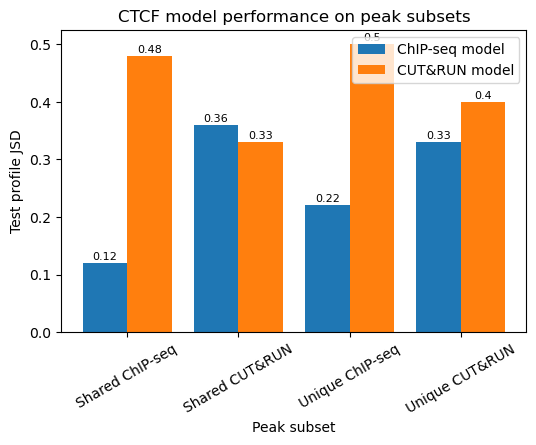

In [10]:
plot_metrics('CTCF', 'Test profile JSD')

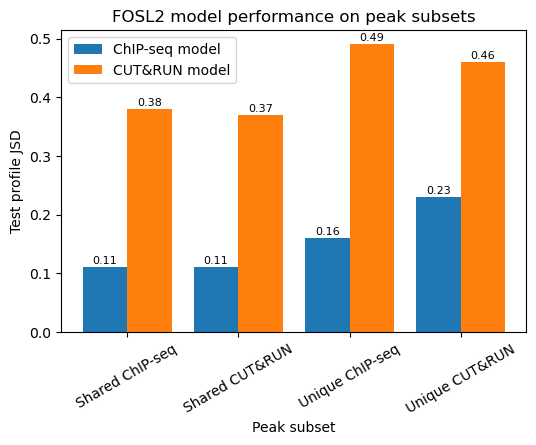

In [8]:
plot_metrics('FOSL2', 'Test profile JSD')

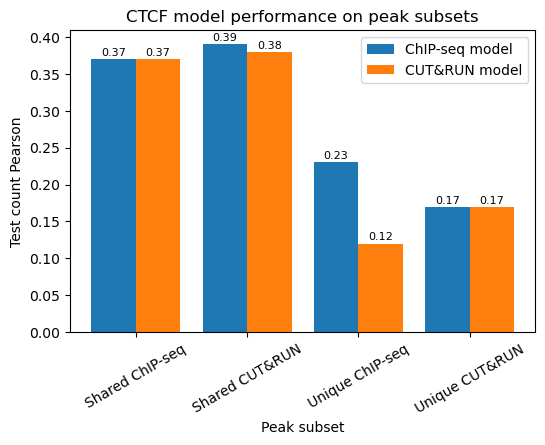

In [9]:
plot_metrics('CTCF', 'Test count Pearson')

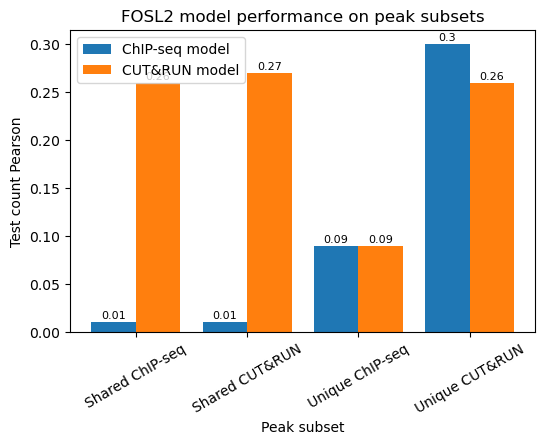

In [10]:
plot_metrics('FOSL2', 'Test count Pearson')

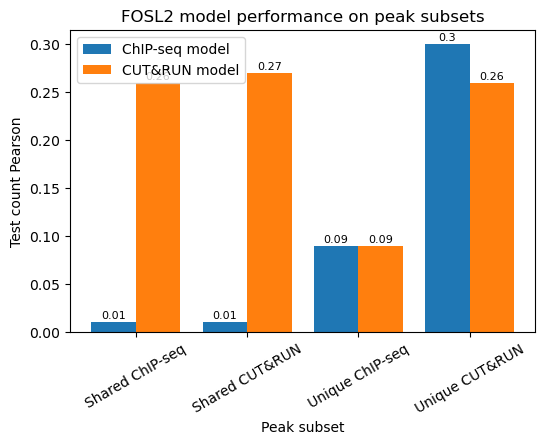

In [11]:
plot_metrics('FOSL2', 'Test count Pearson')

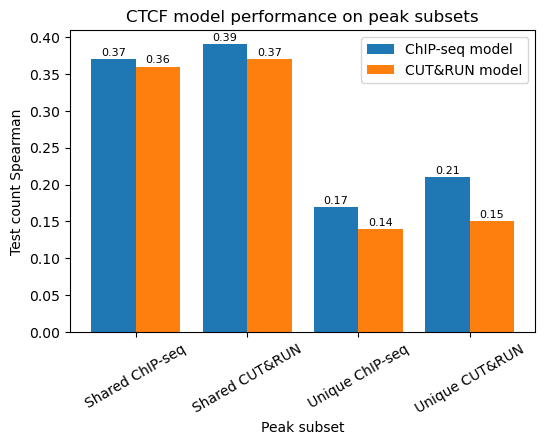

In [12]:
plot_metrics('CTCF', 'Test count Spearman')

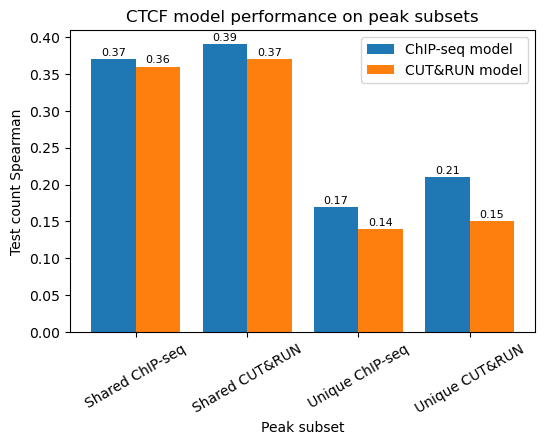

In [13]:
plot_metrics('CTCF', 'Test count Spearman')

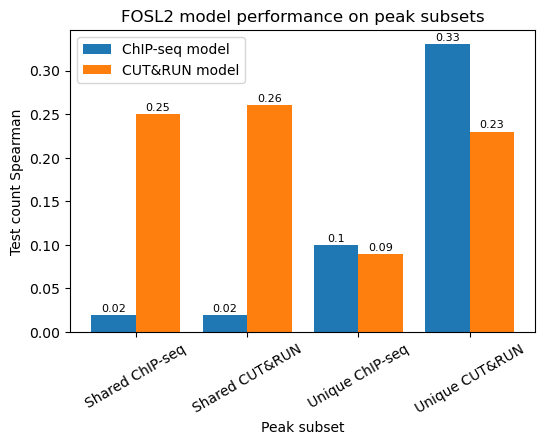

In [14]:
plot_metrics('FOSL2', 'Test count Spearman')

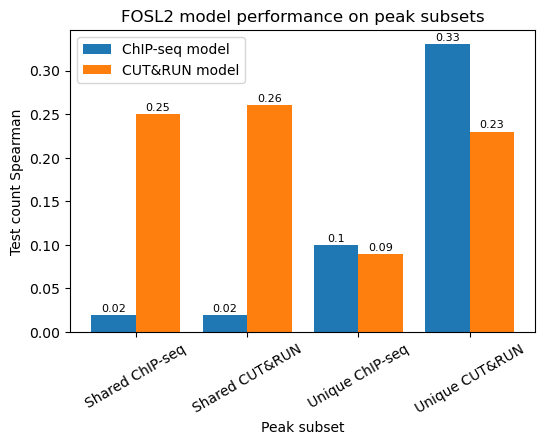

In [15]:
plot_metrics('FOSL2', 'Test count Spearman')

In [46]:
alphas=[1,0.3,0.4,0.02]

In [42]:
def plot_counts_across_subsets(tf, assay):
    ''' Create a scatterplot of true vs pred counts, color coded by peak subset 
        tf : CTCF or FOSL2
        assay: chip-seq or cutnrun 
    '''
    preds_dict = all_preds_dict[f'{tf} {assay} model']
    
    for i, key in enumerate(keys): # shared_chip_loader, etc.
        true_counts = preds_dict[key]['true_counts'].reshape((-1, 2)).sum(axis=1)
        log_pred_counts = preds_dict[key]['log_pred_counts'].reshape((-1, 2)).sum(axis=1)
        plt.scatter(x = true_counts, y = log_pred_counts, color=colors[i], alpha= alphas[i], label=key)
    
    plt.xlabel('true counts')
    plt.ylabel('log pred counts')
    plt.title(f'{tf} {assay} model')
    plt.legend()

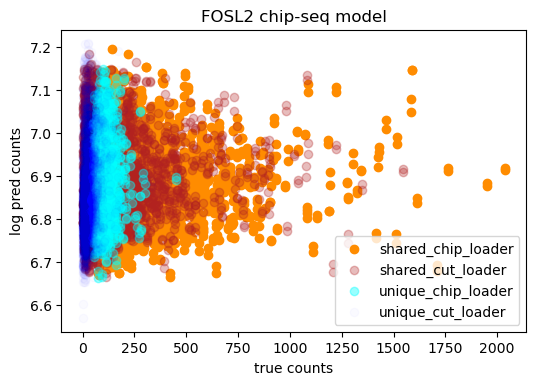

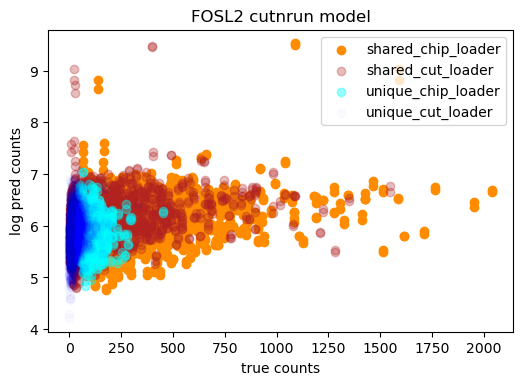

In [48]:
tf = 'FOSL2'
plot_counts_across_subsets(tf, 'chip-seq')
plt.figure()
plot_counts_across_subsets(tf, 'cutnrun')

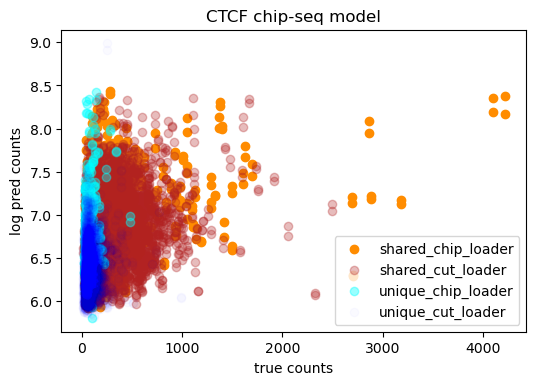

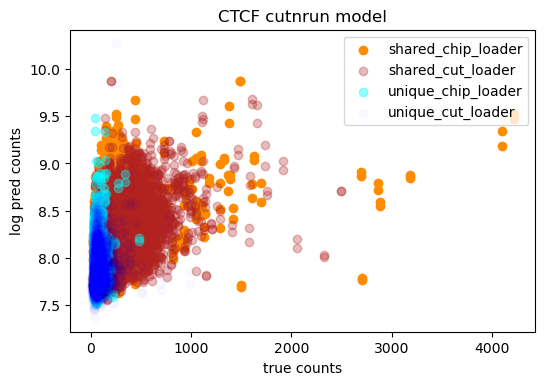

In [47]:
tf = 'CTCF'
plot_counts_across_subsets(tf, 'chip-seq')
plt.figure()
plot_counts_across_subsets(tf, 'cutnrun')

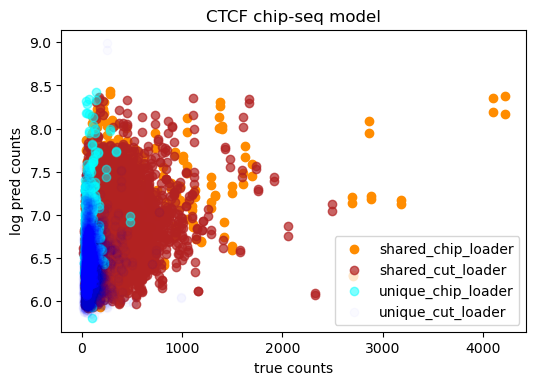

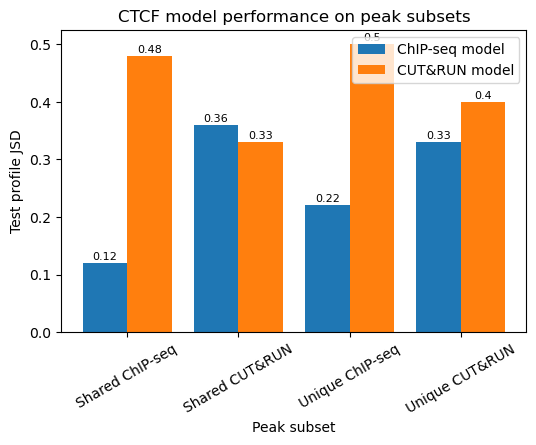

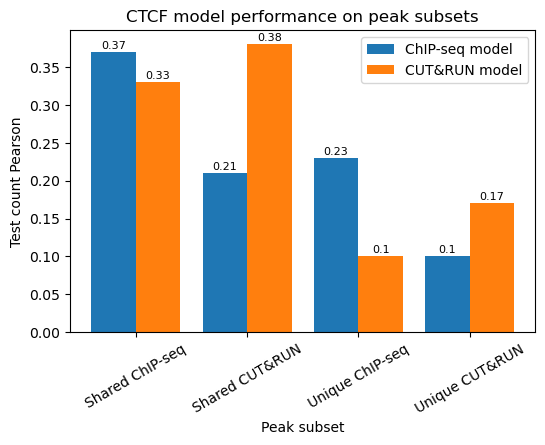

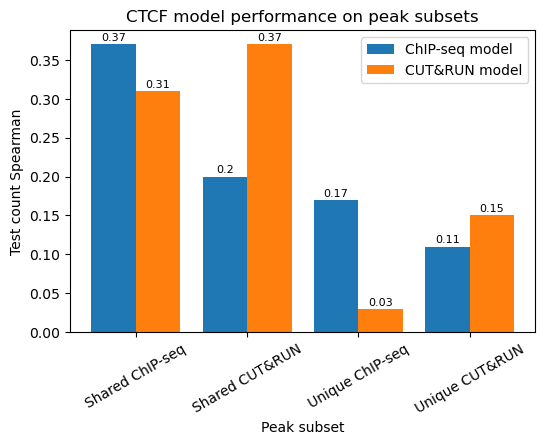

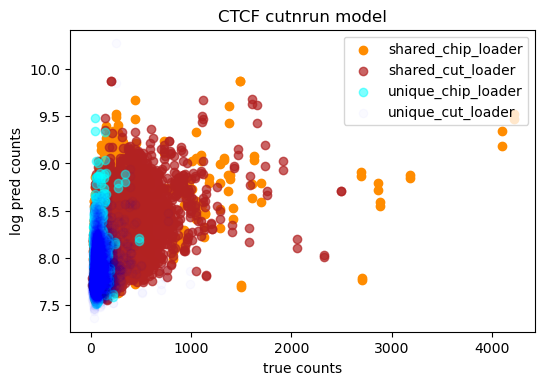

In [35]:
tf = 'CTCF'
plot_counts_across_subsets(tf, 'chip-seq')
plot_metrics(tf, 'Test profile JSD')
plot_metrics(tf, 'Test count Pearson')
plot_metrics(tf, 'Test count Spearman')
plot_counts_across_subsets(tf, 'cutnrun')
#display(metrics.loc[tf + ' ' + 'chip-seq model':tf + ' ' + 'cutnrun model'])